### MIS 6020: Computation and Image Processing

In [1]:
# !pip install nbconvert
import sys
sys.path.append(r'C:\Users\ranab\PycharmProjects\MIS6020\registration')
import utilities as util
from helperFunctions import start_plot, end_plot, update_multires_iterations, plot_values
import SimpleITK as sitk
import nibabel as nib
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output
from skimage.util import compare_images
# from brainextractor import BrainExtractor

In [2]:
fileDir = r'C:\Data\Kirby2009'
fileList = glob(os.path.join(fileDir, '*.nii'))
print(fileList)
mniDir = os.path.join(fileDir, 'MNI_atlas')
mniPath = glob(os.path.join(mniDir, '*.nii'))[0]
print(mniPath)

mrImage = nib.load(fileList[10]).get_fdata()
print("\nmri: ", mrImage.shape)
mniAtlas = nib.load(mniPath).get_fdata()
print("\nmni: ", mniAtlas.shape)

['C:\\Data\\Kirby2009\\KKI2009-01-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-30-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-31-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-32-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-33-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-34-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-35-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-36-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-37-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-38-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-39-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-40-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-41-MPRAGE.nii', 'C:\\Data\\Kirby2009\\KKI2009-42-MPRAGE.nii']
C:\Data\Kirby2009\MNI_atlas\average305_t1_tal_lin.nii

mri:  (170, 256, 256)

mni:  (172, 220, 156)


In [3]:
mrAtlas = np.zeros_like(mrImage)  # write comments... 
for n, fl in enumerate(fileList):
    mrImage_ = nib.load(fl).get_fdata()
    mrAtlas += mrImage_
  # if n>0: mrAtlas /= 2
mrAtlas /= (n+1)

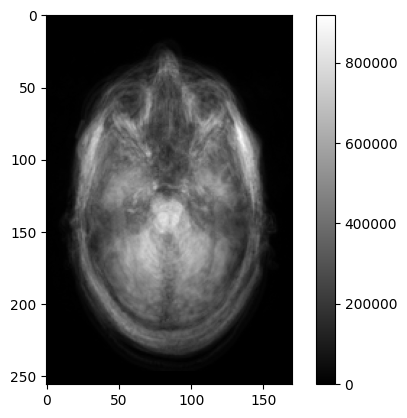

In [4]:
img = mrAtlas[..., -150]
rotated_img = np.rot90(img, k=-1)  # k=1 for 90-degree clockwise rotation
plt.imshow(rotated_img, cmap='gray') # origin='upper')
plt.colorbar()
plt.show()

### 2D registration
Preprocessing: 
- Noise removal.
- Skull trimming in case of head images. 
- B0 inhomogeneity correction. 

Homework:
- Spinal cord image registration? 
- CT to MR? 

In [5]:
# preprocessing
mrAtlas2D = mrAtlas[:,110,:]  #[..., 128]
mrImage2D = mrImage[:, :,128]
mrImage2D = mrImage2D/np.max(mrImage2D)
mniAtlas2D = mniAtlas[:,:, 78]
mniAtlas2D = mniAtlas2D/np.max(mniAtlas2D)

# plt.subplot(133)
# plt.imshow(sitk.GetArrayFromImage(out), cmap='gray')
# plt.show()

fixed >>> (220, 172) 
moving >>> (256, 170)


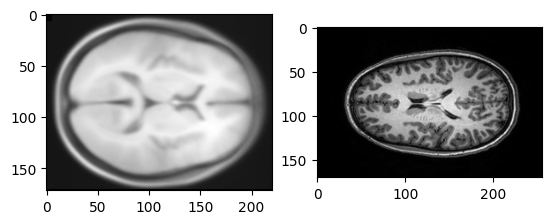

In [6]:
fixedImage = sitk.Cast(sitk.GetImageFromArray(mniAtlas2D), sitk.sitkFloat32)
movingImage = sitk.Cast(sitk.GetImageFromArray(mrImage2D), sitk.sitkFloat32)
print("fixed >>>", fixedImage.GetSize(), "\nmoving >>>", movingImage.GetSize())
plt.subplot(121)
plt.imshow(sitk.GetArrayFromImage(fixedImage), cmap='gray')
plt.subplot(122)
plt.imshow(sitk.GetArrayFromImage(movingImage), cmap='gray')
plt.show()

In [7]:
point = [10, 11]
movingImage.GetSpacing(), movingImage.GetDimension()
dimension = movingImage.GetDimension()
offset = [2]*dimension # use a Python trick to create the offset list based on the dimension
translation = sitk.TranslationTransform(dimension, offset)
print(translation)

itk::simple::TranslationTransform
 TranslationTransform (0000022BA279D580)
   RTTI typeinfo:   class itk::TranslationTransform<double,2>
   Reference Count: 1
   Modified Time: 1739
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [2, 2]



In [9]:
def resample_display(image, euler2d_transform, tx, ty, theta):
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)
    
    resampled_image = sitk.Resample(image, euler2d_transform)
    plt.imshow(sitk.GetArrayFromImage(resampled_image), cmap='gray')
    plt.axis('off')    
    plt.show()

euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(movingImage.TransformContinuousIndexToPhysicalPoint(np.array(movingImage.GetSize())/2.0))
interact(resample_display, image=fixed(movingImage), euler2d_transform=fixed(euler2d), tx=(-128.0, 128.0), ty=(-64.0, 64.0), theta=(-np.pi/2.0,np.pi/2.0));

interactive(children=(FloatSlider(value=0.0, description='tx', max=128.0, min=-128.0), FloatSlider(value=0.0, …

best orientation is: 178.37837837837836
best similarity value -0.5262797124707986


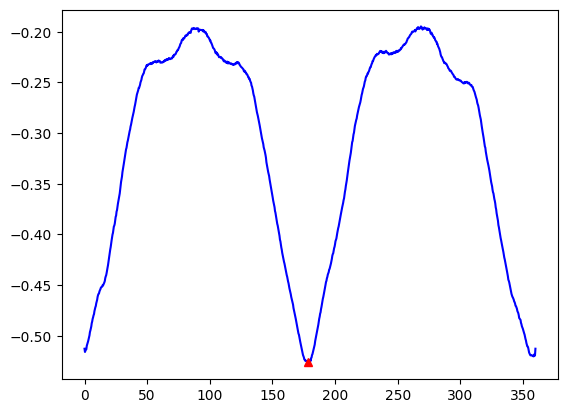

In [11]:
def command_iteration(method):
    global metric_values
    print("metric value: {}".format(method.GetMetricValue()))
    metric_values.append(method.GetMetricValue())
    
metric_values = []  # this is a list where I am going to append/add the values
degrees = np.linspace(0, 360, 1000)  # taking 1000 equidistant points between 0 and 360
radians = np.deg2rad(degrees)
initial_transform = sitk.Euler2DTransform(sitk.CenteredTransformInitializer( # image coordinate is typically in one of the 
    # image corners, this results in counter-intuitive txform, when rotations and scaling are involved.
        fixedImage,
        movingImage,
        sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.MOMENTS))      # updated: from GEOMETRY; MOMENTS is when the intensity of gray levels
# are used. This MOMENTS mode of operation is quite convenient when the anatomical structures of interest are not centered
# in the image.
registration_method = sitk.ImageRegistrationMethod() # creating image registration object.
registration_method.SetInitialTransform(initial_transform, inPlace=False)   # updated from False
registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=0.5,
                                                             minStep=1e-3,
                                                             numberOfIterations=500,
                                                             gradientMagnitudeTolerance=1e-2)
# registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0,
#                                                               numberOfIterations=100,
#                                                               convergenceMinimumValue=1e-6,
#                                                               convergenceWindowSize=10)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerScalesFromIndexShift() # Estimate scales from maximum voxel shift in index space cause by parameter change.
# used for automatic estimation of the parameters scales
best_angle = 0.0  # starting value. 
best_similarity_value = registration_method.MetricEvaluate(fixedImage, movingImage)
similarity_value = []
for i, angle in enumerate(radians):  # .items():
    initial_transform.SetAngle(angle)
    registration_method.SetInitialTransform(initial_transform)
    current_similarity_value = registration_method.MetricEvaluate(fixedImage, movingImage)
    similarity_value.append(current_similarity_value)
    if current_similarity_value < best_similarity_value:
        best_similarity_value = current_similarity_value
        best_angle = np.rad2deg(angle)
# best_angle = 278.9189189189189#310.99099099099095
print('best orientation is: ' + str(best_angle))
print("best similarity value", best_similarity_value)
plt.plot(degrees, similarity_value, 'b')
plt.plot(best_angle, best_similarity_value, 'r^')
plt.show()
# best_angle = 296.93693693693695 # copied to save time.
initial_transform.SetAngle(np.deg2rad(best_angle))
registration_method.SetInitialTransform(initial_transform, inPlace=True)
eulerTx = registration_method.Execute(fixedImage, movingImage)
resampler = sitk.ResampleImageFilter() # performs final mapping process; takes an image, a transform and an interpolator;
# REsampling is performed in space coordinates, not pixel/grid coordinates. 
resampler.SetReferenceImage(fixedImage)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(eulerTx)
out = resampler.Execute(movingImage)

In [1]:
similarity_value_before_affine = registration_method.MetricEvaluate(fixedImage, out)
# affine
affine = sitk.AffineTransform(fixedImage.GetDimension())
print(affine.GetParameters())
metric_values = []
registration_method.SetMovingInitialTransform(eulerTx)
registration_method.SetInitialTransform(affine, inPlace=True)
# registration_method.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsANTSNeighborhoodCorrelation(20)
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.NONE) # NONE
# registration_method.SetMetricSamplingPercentage(0.01)
# registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerScalesFromIndexShift()
# registration_method.SetOptimizerAsGradientDescent(
#     learningRate=0.05,
#     numberOfIterations=1000,
#     convergenceMinimumValue=1e-10,
#     convergenceWindowSize=250,
#     estimateLearningRate=registration_method.EachIteration,
# )
# registration_method.SetOptimizerAsConjugateGradientLineSearch(
#     learningRate=0.05,
#     numberOfIterations=1000,
#     convergenceMinimumValue=1e-6,
#     convergenceWindowSize=250,
# )
registration_method.SetOptimizerAsRegularStepGradientDescent( # this one
    learningRate=.05,
     minStep=1e-4,
     numberOfIterations=1000,
     gradientMagnitudeTolerance=1e-8)
# growthFactor=1.25
# registration_method.SetOptimizerAsOnePlusOneEvolutionary(growthFactor=growthFactor, 
#                                                          shrinkFactor=growthFactor**(0.25), 
#                                                          epsilon=1.5e-6, 
#                                                          initialRadius=6.25e-3/3, 
#                                                          numberOfIterations=200, 
#                                                          seed=42
#                                                         )
# registration_method.SetOptimizerAsLBFGSB(maximumNumberOfFunctionEvaluations=2000,lowerBound=-5.0,upperBound=5.0)
# registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
# registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
# registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
# registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
# registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
affineTx = registration_method.Execute(fixedImage, movingImage)
compositeTx = sitk.CompositeTransform([eulerTx, affineTx])

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixedImage)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(compositeTx)
out = resampler.Execute(movingImage)

plt.plot(metric_values)
plt.show()

print(affineTx.GetParameters())

NameError: name 'registration_method' is not defined

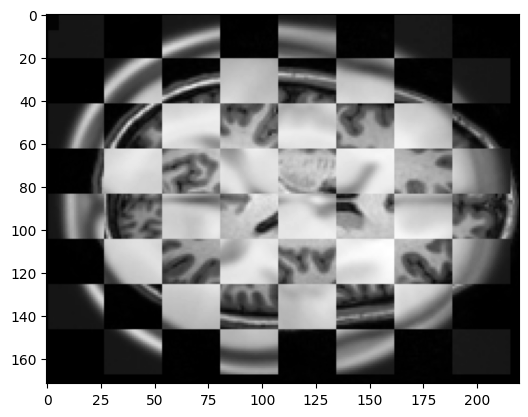

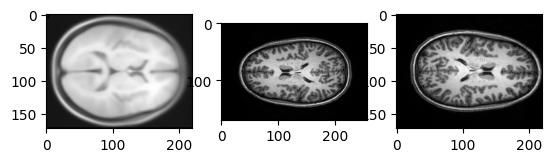

In [22]:
comp_equalized = compare_images(sitk.GetArrayFromImage(fixedImage),
                                sitk.GetArrayFromImage(out),
                                method='checkerboard')
plt.imshow(comp_equalized, cmap='gray')
plt.show()

plt.subplot(131)
plt.imshow(sitk.GetArrayFromImage(fixedImage), cmap='gray')
plt.subplot(132)
plt.imshow(sitk.GetArrayFromImage(movingImage), cmap='gray')
plt.subplot(133)
plt.imshow(sitk.GetArrayFromImage(out), cmap='gray')
plt.show()

### Multi-resolution/pyramid framework

In [2]:
similarity_value_before_affine = registration_method.MetricEvaluate(fixedImage, out)
# affine
affine = sitk.AffineTransform(fixedImage.GetDimension())
print(affine.GetParameters())
metric_values = []
registration_method.SetMovingInitialTransform(eulerTx)
registration_method.SetInitialTransform(affine, inPlace=True)
# registration_method.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsANTSNeighborhoodCorrelation(20)
registration_method.SetMetricSamplingStrategy(registration_method.NONE)
# registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerScalesFromIndexShift()
# registration_method.SetOptimizerAsGradientDescent(
#     learningRate=0.05,
#     numberOfIterations=1000,
#     convergenceMinimumValue=1e-10,
#     convergenceWindowSize=250,
#     estimateLearningRate=registration_method.EachIteration,
# )
# registration_method.SetOptimizerAsConjugateGradientLineSearch(
#     learningRate=0.05,
#     numberOfIterations=1000,
#     convergenceMinimumValue=1e-6,
#     convergenceWindowSize=250,
# )
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=.05,
     minStep=1e-4,
     numberOfIterations=1000,
     gradientMagnitudeTolerance=1e-8)

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
affineTx = registration_method.Execute(fixedImage, movingImage)
compositeTx = sitk.CompositeTransform([eulerTx, affineTx])

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixedImage)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(compositeTx)
out = resampler.Execute(movingImage)

# plt.plot(metric_values)
# plt.show()

print(affineTx.GetParameters())

NameError: name 'registration_method' is not defined

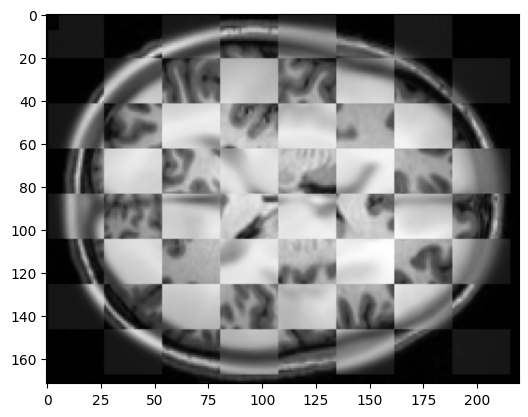

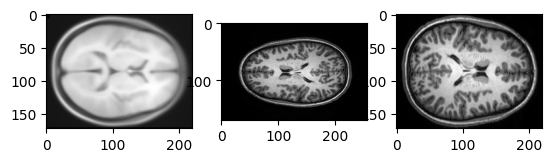

In [24]:
comp_equalized = compare_images(sitk.GetArrayFromImage(fixedImage),
                                sitk.GetArrayFromImage(out),
                                method='checkerboard')
plt.imshow(comp_equalized, cmap='gray')
plt.show()

plt.subplot(131)
plt.imshow(sitk.GetArrayFromImage(fixedImage), cmap='gray')
plt.subplot(132)
plt.imshow(sitk.GetArrayFromImage(movingImage), cmap='gray')
plt.subplot(133)
plt.imshow(sitk.GetArrayFromImage(out), cmap='gray')
plt.show()

multi-resolution framework improves registration performance which is visible in decreasing metric and qualitative axial images. 

### 3D Registration

In [16]:
mrImage = mrImage/np.max(mrImage)
mniAtlas = mniAtlas/np.max(mniAtlas)
fixed_image = sitk.Cast(sitk.GetImageFromArray(mniAtlas), sitk.sitkFloat32)
moving_image = sitk.Cast(sitk.GetImageFromArray(mrImage), sitk.sitkFloat32)
print("fixed >>>", fixed_image.GetSize(), "\nmoving >>>", moving_image.GetSize())

fixed >>> (156, 220, 172) 
moving >>> (256, 256, 170)


In [17]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)
moving_resampled = sitk.Resample(moving_image, 
                                 fixed_image, 
                                 initial_transform, 
                                 sitk.sitkLinear, 0.0, 
                                 moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=85, description='image_z', max=171), FloatSlider(value=0.5, description=…

In [3]:
# similarity_value_before_affine = registration_method.MetricEvaluate(fixedImage, out)
# affine
affine = sitk.AffineTransform(fixedImage.GetDimension())
print(affine.GetParameters())
metric_values = []
registration_method = sitk.ImageRegistrationMethod()
# registration_method.SetMovingInitialTransform(eulerTx)
registration_method.SetInitialTransform(initial_transform, inPlace=True)
# registration_method.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricAsANTSNeighborhoodCorrelation(20)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM) # NONE
registration_method.SetMetricSamplingPercentage(0.01)
# registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerScalesFromIndexShift()
# registration_method.SetOptimizerAsGradientDescent(
#     learningRate=0.05,
#     numberOfIterations=1000,
#     convergenceMinimumValue=1e-10,
#     convergenceWindowSize=250,
#     estimateLearningRate=registration_method.EachIteration,
# )
# registration_method.SetOptimizerAsConjugateGradientLineSearch(
#     learningRate=0.05,
#     numberOfIterations=1000,
#     convergenceMinimumValue=1e-6,
#     convergenceWindowSize=250,
# )
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=.05,
     minStep=1e-4,
     numberOfIterations=1000,
     gradientMagnitudeTolerance=1e-8)

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
affineTx = registration_method.Execute(fixedImage, movingImage)
# compositeTx = sitk.CompositeTransform([eulerTx, affineTx])

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixedImage)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(affineTx)
out = resampler.Execute(movingImage)

plt.plot(metric_values)
plt.show()

print(affineTx.GetParameters())

NameError: name 'sitk' is not defined

### About registration: 
There are four elements in a registration framework:
- **Two images**: fixed image and moving image.  
- **Metric**: 
- **Optimizer**:
- **Interpolator**:

Multi-resolution registration is like algorithmic _"squinting"_ by using image pyramids. Start registration at easy low resolution images to seed parameters and then to high resolution - _coarse-to-fine_. 

**Reference**:
1. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html
2. for 2D registration suggestion github/zivy https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/60_Registration_Introduction.ipynb
3. This example uses `histogram matcher` for grayscale source image: https://simpleitk.org/doxygen/latest/html/DemonsRegistration2_2DemonsRegistration2_8py-example.html
4. Registration initializer: we have to start somewhere http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/63_Registration_Initialization.html
    - `sitk.CenteredTransformInitializer` assumes image orientation is similar.  
5. Demon algorithms in multiresolution setting: https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/66_Registration_Demons.ipynb from @zivy
6. Affine registration:  https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/61_Registration_Introduction_Continued.ipynb
    - About affine parameters: https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch3.html#x26-110175r30

### Issues remaining:
1. `DisplacementFieldTransform` thing has iteration issues. Doesn't run more than 8. 
2. Though `FastSymmetricForcesDemonsRegistrationFilter` works great but parameters and all are not understood. 

`TransformToDisplacementFieldFilter` with `SetMetricAsDemons(1)` where 1 means the difference of 1 in intensity is considered equal pixel, doesn't generate good registration.
<!-- ![image.png](attachment:image.png) ![image.png](attachment:image.png) -->